In [4]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [5]:
def load_cifar10(batch=128):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )
 
    test_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
        shuffle=True
    )
 
    return {'train': train_loader, 'test': test_loader}

Files already downloaded and verified
Files already downloaded and verified
torch.Size([128, 3, 32, 32])


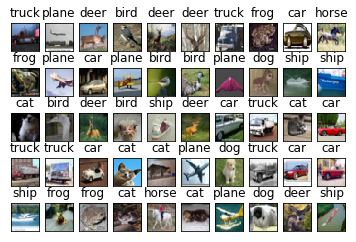

In [6]:
if __name__ == '__main__':
    loader = load_cifar10()
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')  # CIFAR10のクラス
 
    for images, labels in loader['train']:
        print(images.shape)  # torch.Size([128, 3, 32, 32])
 
        # 試しに50枚を 5x10 で見てみる
        for i in range(5):
            for j in range(10):
                image = images[i*10+j] / 2 + 0.5
                image = image.numpy()
                plt.subplot(5, 10, i*10+j + 1)
                plt.imshow(np.transpose(image, (1, 2, 0)))  # matplotlibではチャネルは第3次元
                
                # 対応するラベル
                plt.title(classes[int(labels[i*10+j])])
                
                # 軸目盛や値はいらないので消す
                plt.tick_params(labelbottom=False,
                                labelleft=False,
                                labelright=False,
                                labeltop=False,
                                bottom=False,
                                left=False,
                                right=False,
                                top=False)
 
        plt.show()
        break

In [11]:
class MyCNN(torch.nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3,  # チャネル入力
                                     6,  # チャンネル出力
                                     5,  # カーネルサイズ
                                     1,  # ストライド (デフォルトは1)
                                     0,  # パディング (デフォルトは0)
                                     )
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
 
        self.pool = torch.nn.MaxPool2d(2, 2)  # カーネルサイズ, ストライド
 
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)  # 入力サイズ, 出力サイズ
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)
 
    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = self.pool(x)
        x = f.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)  # 1次元データに変えて全結合層へ
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
 
        return x

    def plot_conv1(self, prefix_num=0):
        weights1 = self.conv1.weight
        weights1 = weights1.reshape(3*6, 5, 5)
 
        for i, weight in enumerate(weights1):
            plt.subplot(3, 6, i + 1)
            plt.imshow(weight.data.numpy(), cmap='winter')
            plt.tick_params(labelbottom=False,
                            labelleft=False,
                            labelright=False,
                            labeltop=False,
                            bottom=False,
                            left=False,
                            right=False,
                            top=False)
 
        plt.savefig('img/{}_conv1.png'.format(prefix_num))
        plt.close()
 
    def plot_conv2(self, prefix_num=0):
        weights2 = self.conv2.weight
        weights2 = weights2.reshape(6*16, 5, 5)
 
        for i, weight in enumerate(weights2):
            plt.subplot(6, 16, i + 1)
            plt.imshow(weight.data.numpy(), cmap='winter')
            plt.tick_params(labelbottom=False,
                            labelleft=False,
                            labelright=False,
                            labeltop=False,
                            bottom=False,
                            left=False,
                            right=False,
                            top=False)
 
        plt.savefig('img/{}_conv2.png'.format(prefix_num))
        plt.close()

In [12]:
if __name__ == '__main__':
    epoch = 50
 
    loader = load_cifar10()
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
 
    net: MyCNN = MyCNN()
    criterion = torch.nn.CrossEntropyLoss()  # ロスの計算
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)
 
    # 学習前のフィルタの可視化
    net.plot_conv1()
    net.plot_conv2()
 
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }
 
    for e in range(epoch):
        net.train()
        loss = None
        for i, (images, labels) in enumerate(loader['train']):
            optimizer.zero_grad()
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
 
            if i % 10 == 0:
                print('Training log: {} epoch ({} / 50000 train. data). Loss: {}'.format(e + 1,
                                                                                         (i + 1) * 128,
                                                                                         loss.item())
                      )
 
        # 学習過程でのフィルタの可視化
        net.plot_conv1(e+1)
        net.plot_conv2(e+1)
 
        history['train_loss'].append(loss.item())
        
        net.eval()
        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(tqdm(loader['train'])):
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
 
        acc = float(correct / 50000)
        history['train_acc'].append(acc)
 
        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(tqdm(loader['test'])):
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
 
        acc = float(correct / 10000)
        history['test_acc'].append(acc)
 
    # 結果をプロット
    plt.plot(range(1, epoch+1), history['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('img/cifar10_loss.png')
    plt.close()
 
    plt.plot(range(1, epoch + 1), history['train_acc'], label='train_acc')
    plt.plot(range(1, epoch + 1), history['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('img/cifar10_acc.png')
    plt.close()

Files already downloaded and verified
Files already downloaded and verified
Training log: 1 epoch (128 / 50000 train. data). Loss: 2.307882070541382
Training log: 1 epoch (1408 / 50000 train. data). Loss: 2.3023037910461426
Training log: 1 epoch (2688 / 50000 train. data). Loss: 2.307725667953491
Training log: 1 epoch (3968 / 50000 train. data). Loss: 2.294236898422241
Training log: 1 epoch (5248 / 50000 train. data). Loss: 2.302727699279785
Training log: 1 epoch (6528 / 50000 train. data). Loss: 2.308846950531006
Training log: 1 epoch (7808 / 50000 train. data). Loss: 2.3003737926483154
Training log: 1 epoch (9088 / 50000 train. data). Loss: 2.304877758026123
Training log: 1 epoch (10368 / 50000 train. data). Loss: 2.3040683269500732
Training log: 1 epoch (11648 / 50000 train. data). Loss: 2.306861162185669
Training log: 1 epoch (12928 / 50000 train. data). Loss: 2.3006410598754883
Training log: 1 epoch (14208 / 50000 train. data). Loss: 2.310300827026367
Training log: 1 epoch (15488 


 67%|█████████████████████████████████████████████████████▌                          | 262/391 [00:08<00:04, 31.40it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.83it/s]

Training log: 2 epoch (128 / 50000 train. data). Loss: 2.293579578399658
Training log: 2 epoch (1408 / 50000 train. data). Loss: 2.3025572299957275
Training log: 2 epoch (2688 / 50000 train. data). Loss: 2.2995684146881104
Training log: 2 epoch (3968 / 50000 train. data). Loss: 2.2952353954315186
Training log: 2 epoch (5248 / 50000 train. data). Loss: 2.3023762702941895
Training log: 2 epoch (6528 / 50000 train. data). Loss: 2.2995071411132812
Training log: 2 epoch (7808 / 50000 train. data). Loss: 2.2962098121643066
Training log: 2 epoch (9088 / 50000 train. data). Loss: 2.3010082244873047
Training log: 2 epoch (10368 / 50000 train. data). Loss: 2.292959451675415
Training log: 2 epoch (11648 / 50000 train. data). Loss: 2.2857162952423096
Training log: 2 epoch (12928 / 50000 train. data). Loss: 2.2939422130584717
Training log: 2 epoch (14208 / 50000 train. data). Loss: 2.29701828956604
Training log: 2 epoch (15488 / 50000 train. data). Loss: 2.292569160461426
Training log: 2 epoch (167


 67%|█████████████████████████████████████████████████████▌                          | 262/391 [00:08<00:04, 31.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.59it/s]


Training log: 3 epoch (128 / 50000 train. data). Loss: 2.272580146789551
Training log: 3 epoch (1408 / 50000 train. data). Loss: 2.269031286239624
Training log: 3 epoch (2688 / 50000 train. data). Loss: 2.255573034286499
Training log: 3 epoch (3968 / 50000 train. data). Loss: 2.2580788135528564
Training log: 3 epoch (5248 / 50000 train. data). Loss: 2.2848784923553467
Training log: 3 epoch (6528 / 50000 train. data). Loss: 2.24082612991333
Training log: 3 epoch (7808 / 50000 train. data). Loss: 2.2564094066619873
Training log: 3 epoch (9088 / 50000 train. data). Loss: 2.2481584548950195
Training log: 3 epoch (10368 / 50000 train. data). Loss: 2.222078561782837
Training log: 3 epoch (11648 / 50000 train. data). Loss: 2.215730667114258
Training log: 3 epoch (12928 / 50000 train. data). Loss: 2.220545768737793
Training log: 3 epoch (14208 / 50000 train. data). Loss: 2.201176643371582
Training log: 3 epoch (15488 / 50000 train. data). Loss: 2.2195699214935303
Training log: 3 epoch (16768 /


 67%|█████████████████████████████████████████████████████▍                          | 261/391 [00:08<00:04, 31.65it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.44it/s]

Training log: 4 epoch (128 / 50000 train. data). Loss: 2.0555217266082764
Training log: 4 epoch (1408 / 50000 train. data). Loss: 2.0518813133239746
Training log: 4 epoch (2688 / 50000 train. data). Loss: 2.09881591796875
Training log: 4 epoch (3968 / 50000 train. data). Loss: 2.05726957321167
Training log: 4 epoch (5248 / 50000 train. data). Loss: 2.0772652626037598
Training log: 4 epoch (6528 / 50000 train. data). Loss: 2.0969886779785156
Training log: 4 epoch (7808 / 50000 train. data). Loss: 2.0984139442443848
Training log: 4 epoch (9088 / 50000 train. data). Loss: 2.1169052124023438
Training log: 4 epoch (10368 / 50000 train. data). Loss: 2.0336005687713623
Training log: 4 epoch (11648 / 50000 train. data). Loss: 2.022156000137329
Training log: 4 epoch (12928 / 50000 train. data). Loss: 2.031336545944214
Training log: 4 epoch (14208 / 50000 train. data). Loss: 2.1131579875946045
Training log: 4 epoch (15488 / 50000 train. data). Loss: 2.0528087615966797
Training log: 4 epoch (1676


 67%|█████████████████████████████████████████████████████▊                          | 263/391 [00:08<00:04, 31.75it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 32.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.07it/s]

Training log: 5 epoch (128 / 50000 train. data). Loss: 1.9863446950912476
Training log: 5 epoch (1408 / 50000 train. data). Loss: 1.9408817291259766
Training log: 5 epoch (2688 / 50000 train. data). Loss: 2.003718137741089
Training log: 5 epoch (3968 / 50000 train. data). Loss: 1.8085453510284424
Training log: 5 epoch (5248 / 50000 train. data). Loss: 1.9283642768859863
Training log: 5 epoch (6528 / 50000 train. data). Loss: 1.9211262464523315
Training log: 5 epoch (7808 / 50000 train. data). Loss: 1.834610104560852
Training log: 5 epoch (9088 / 50000 train. data). Loss: 1.9983428716659546
Training log: 5 epoch (10368 / 50000 train. data). Loss: 1.8693056106567383
Training log: 5 epoch (11648 / 50000 train. data). Loss: 1.990615725517273
Training log: 5 epoch (12928 / 50000 train. data). Loss: 1.8524627685546875
Training log: 5 epoch (14208 / 50000 train. data). Loss: 1.9299049377441406
Training log: 5 epoch (15488 / 50000 train. data). Loss: 1.9238874912261963
Training log: 5 epoch (1


 64%|███████████████████████████████████████████████████▏                            | 250/391 [00:08<00:04, 30.86it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.27it/s]


Training log: 6 epoch (128 / 50000 train. data). Loss: 1.7638435363769531
Training log: 6 epoch (1408 / 50000 train. data). Loss: 1.8469624519348145
Training log: 6 epoch (2688 / 50000 train. data). Loss: 1.8175157308578491
Training log: 6 epoch (3968 / 50000 train. data). Loss: 1.8278217315673828
Training log: 6 epoch (5248 / 50000 train. data). Loss: 1.7452224493026733
Training log: 6 epoch (6528 / 50000 train. data). Loss: 1.6681948900222778
Training log: 6 epoch (7808 / 50000 train. data). Loss: 1.7852357625961304
Training log: 6 epoch (9088 / 50000 train. data). Loss: 1.77206552028656
Training log: 6 epoch (10368 / 50000 train. data). Loss: 1.7795119285583496
Training log: 6 epoch (11648 / 50000 train. data). Loss: 1.7595252990722656
Training log: 6 epoch (12928 / 50000 train. data). Loss: 1.987220048904419
Training log: 6 epoch (14208 / 50000 train. data). Loss: 1.7671276330947876
Training log: 6 epoch (15488 / 50000 train. data). Loss: 1.8029282093048096
Training log: 6 epoch (1


 66%|████████████████████████████████████████████████████▉                           | 259/391 [00:08<00:04, 31.26it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.64it/s]

Training log: 7 epoch (128 / 50000 train. data). Loss: 1.7859001159667969
Training log: 7 epoch (1408 / 50000 train. data). Loss: 1.5679420232772827
Training log: 7 epoch (2688 / 50000 train. data). Loss: 1.8702013492584229
Training log: 7 epoch (3968 / 50000 train. data). Loss: 1.853171706199646
Training log: 7 epoch (5248 / 50000 train. data). Loss: 1.7018053531646729
Training log: 7 epoch (6528 / 50000 train. data). Loss: 1.7472032308578491
Training log: 7 epoch (7808 / 50000 train. data). Loss: 1.810146689414978
Training log: 7 epoch (9088 / 50000 train. data). Loss: 1.5885733366012573
Training log: 7 epoch (10368 / 50000 train. data). Loss: 1.6900742053985596
Training log: 7 epoch (11648 / 50000 train. data). Loss: 1.6706513166427612
Training log: 7 epoch (12928 / 50000 train. data). Loss: 1.748802661895752
Training log: 7 epoch (14208 / 50000 train. data). Loss: 1.7286139726638794
Training log: 7 epoch (15488 / 50000 train. data). Loss: 1.7069144248962402
Training log: 7 epoch (1


 65%|███████████████████████████████████████████████████▉                            | 254/391 [00:08<00:04, 31.58it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.42it/s]


Training log: 8 epoch (128 / 50000 train. data). Loss: 1.6549915075302124
Training log: 8 epoch (1408 / 50000 train. data). Loss: 1.74185311794281
Training log: 8 epoch (2688 / 50000 train. data). Loss: 1.8159372806549072
Training log: 8 epoch (3968 / 50000 train. data). Loss: 1.7196173667907715
Training log: 8 epoch (5248 / 50000 train. data). Loss: 1.9351942539215088
Training log: 8 epoch (6528 / 50000 train. data). Loss: 1.6911723613739014
Training log: 8 epoch (7808 / 50000 train. data). Loss: 1.7035775184631348
Training log: 8 epoch (9088 / 50000 train. data). Loss: 1.6976914405822754
Training log: 8 epoch (10368 / 50000 train. data). Loss: 1.7575417757034302
Training log: 8 epoch (11648 / 50000 train. data). Loss: 1.6372203826904297
Training log: 8 epoch (12928 / 50000 train. data). Loss: 1.621077299118042
Training log: 8 epoch (14208 / 50000 train. data). Loss: 1.6202609539031982
Training log: 8 epoch (15488 / 50000 train. data). Loss: 1.6772701740264893
Training log: 8 epoch (1


 65%|████████████████████████████████████████████████████▏                           | 255/391 [00:08<00:04, 31.67it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 32.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.11it/s]

Training log: 9 epoch (128 / 50000 train. data). Loss: 1.708803415298462
Training log: 9 epoch (1408 / 50000 train. data). Loss: 1.8291006088256836
Training log: 9 epoch (2688 / 50000 train. data). Loss: 1.6210119724273682
Training log: 9 epoch (3968 / 50000 train. data). Loss: 1.6757497787475586
Training log: 9 epoch (5248 / 50000 train. data). Loss: 1.727994441986084
Training log: 9 epoch (6528 / 50000 train. data). Loss: 1.6490198373794556
Training log: 9 epoch (7808 / 50000 train. data). Loss: 1.7132549285888672
Training log: 9 epoch (9088 / 50000 train. data). Loss: 1.5085936784744263
Training log: 9 epoch (10368 / 50000 train. data). Loss: 1.5103377103805542
Training log: 9 epoch (11648 / 50000 train. data). Loss: 1.7021865844726562
Training log: 9 epoch (12928 / 50000 train. data). Loss: 1.3512176275253296
Training log: 9 epoch (14208 / 50000 train. data). Loss: 1.481535792350769
Training log: 9 epoch (15488 / 50000 train. data). Loss: 1.5734590291976929
Training log: 9 epoch (1


 67%|█████████████████████████████████████████████████████▊                          | 263/391 [00:08<00:04, 31.64it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 32.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.82it/s]

Training log: 10 epoch (128 / 50000 train. data). Loss: 1.5759191513061523
Training log: 10 epoch (1408 / 50000 train. data). Loss: 1.5965675115585327
Training log: 10 epoch (2688 / 50000 train. data). Loss: 1.4972589015960693
Training log: 10 epoch (3968 / 50000 train. data). Loss: 1.5802980661392212
Training log: 10 epoch (5248 / 50000 train. data). Loss: 1.7476170063018799
Training log: 10 epoch (6528 / 50000 train. data). Loss: 1.4962170124053955
Training log: 10 epoch (7808 / 50000 train. data). Loss: 1.645041584968567
Training log: 10 epoch (9088 / 50000 train. data). Loss: 1.5868276357650757
Training log: 10 epoch (10368 / 50000 train. data). Loss: 1.4873560667037964
Training log: 10 epoch (11648 / 50000 train. data). Loss: 1.637346863746643
Training log: 10 epoch (12928 / 50000 train. data). Loss: 1.5741147994995117
Training log: 10 epoch (14208 / 50000 train. data). Loss: 1.4742686748504639
Training log: 10 epoch (15488 / 50000 train. data). Loss: 1.6221147775650024
Training l


 64%|███████████████████████████████████████████████████▌                            | 252/391 [00:08<00:04, 31.12it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.88it/s]


Training log: 11 epoch (128 / 50000 train. data). Loss: 1.561928629875183
Training log: 11 epoch (1408 / 50000 train. data). Loss: 1.4061843156814575
Training log: 11 epoch (2688 / 50000 train. data). Loss: 1.464511513710022
Training log: 11 epoch (3968 / 50000 train. data). Loss: 1.4831929206848145
Training log: 11 epoch (5248 / 50000 train. data). Loss: 1.6384485960006714
Training log: 11 epoch (6528 / 50000 train. data). Loss: 1.4325287342071533
Training log: 11 epoch (7808 / 50000 train. data). Loss: 1.6054350137710571
Training log: 11 epoch (9088 / 50000 train. data). Loss: 1.542391300201416
Training log: 11 epoch (10368 / 50000 train. data). Loss: 1.498329520225525
Training log: 11 epoch (11648 / 50000 train. data). Loss: 1.5158833265304565
Training log: 11 epoch (12928 / 50000 train. data). Loss: 1.5066004991531372
Training log: 11 epoch (14208 / 50000 train. data). Loss: 1.4640097618103027
Training log: 11 epoch (15488 / 50000 train. data). Loss: 1.4544920921325684
Training log


 66%|████████████████████████████████████████████████████▊                           | 258/391 [00:08<00:04, 31.25it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.72it/s]

Training log: 12 epoch (128 / 50000 train. data). Loss: 1.3415521383285522
Training log: 12 epoch (1408 / 50000 train. data). Loss: 1.5512551069259644
Training log: 12 epoch (2688 / 50000 train. data). Loss: 1.4551775455474854
Training log: 12 epoch (3968 / 50000 train. data). Loss: 1.4275703430175781
Training log: 12 epoch (5248 / 50000 train. data). Loss: 1.5045247077941895
Training log: 12 epoch (6528 / 50000 train. data). Loss: 1.428891658782959
Training log: 12 epoch (7808 / 50000 train. data). Loss: 1.5169967412948608
Training log: 12 epoch (9088 / 50000 train. data). Loss: 1.5487213134765625
Training log: 12 epoch (10368 / 50000 train. data). Loss: 1.4646110534667969
Training log: 12 epoch (11648 / 50000 train. data). Loss: 1.5544562339782715
Training log: 12 epoch (12928 / 50000 train. data). Loss: 1.501333236694336
Training log: 12 epoch (14208 / 50000 train. data). Loss: 1.4483890533447266
Training log: 12 epoch (15488 / 50000 train. data). Loss: 1.5058811902999878
Training l


 53%|██████████████████████████████████████████▎                                     | 207/391 [00:09<00:07, 25.15it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.83it/s]

 27%|█████████████████████▊                                                            | 21/79 [00:00<00:02, 24.35it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 23.82it/s]


Training log: 13 epoch (128 / 50000 train. data). Loss: 1.3868008852005005
Training log: 13 epoch (1408 / 50000 train. data). Loss: 1.5324547290802002
Training log: 13 epoch (2688 / 50000 train. data). Loss: 1.5150431394577026
Training log: 13 epoch (3968 / 50000 train. data). Loss: 1.3773362636566162
Training log: 13 epoch (5248 / 50000 train. data). Loss: 1.479285478591919
Training log: 13 epoch (6528 / 50000 train. data). Loss: 1.4695770740509033
Training log: 13 epoch (7808 / 50000 train. data). Loss: 1.3452999591827393
Training log: 13 epoch (9088 / 50000 train. data). Loss: 1.4793486595153809
Training log: 13 epoch (10368 / 50000 train. data). Loss: 1.4729697704315186
Training log: 13 epoch (11648 / 50000 train. data). Loss: 1.372950792312622
Training log: 13 epoch (12928 / 50000 train. data). Loss: 1.4041438102722168
Training log: 13 epoch (14208 / 50000 train. data). Loss: 1.4251723289489746
Training log: 13 epoch (15488 / 50000 train. data). Loss: 1.6453315019607544
Training l


 66%|████████████████████████████████████████████████████▊                           | 258/391 [00:08<00:04, 31.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.80it/s]

Training log: 14 epoch (128 / 50000 train. data). Loss: 1.501020073890686
Training log: 14 epoch (1408 / 50000 train. data). Loss: 1.3756873607635498
Training log: 14 epoch (2688 / 50000 train. data). Loss: 1.3572221994400024
Training log: 14 epoch (3968 / 50000 train. data). Loss: 1.2825297117233276
Training log: 14 epoch (5248 / 50000 train. data). Loss: 1.3137812614440918
Training log: 14 epoch (6528 / 50000 train. data). Loss: 1.4408756494522095
Training log: 14 epoch (7808 / 50000 train. data). Loss: 1.3543790578842163
Training log: 14 epoch (9088 / 50000 train. data). Loss: 1.375756025314331
Training log: 14 epoch (10368 / 50000 train. data). Loss: 1.5215201377868652
Training log: 14 epoch (11648 / 50000 train. data). Loss: 1.356859564781189
Training log: 14 epoch (12928 / 50000 train. data). Loss: 1.4735509157180786
Training log: 14 epoch (14208 / 50000 train. data). Loss: 1.5381553173065186
Training log: 14 epoch (15488 / 50000 train. data). Loss: 1.4012055397033691
Training lo


 68%|██████████████████████████████████████████████████████▏                         | 265/391 [00:08<00:04, 31.33it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.85it/s]

Training log: 15 epoch (128 / 50000 train. data). Loss: 1.2300889492034912
Training log: 15 epoch (1408 / 50000 train. data). Loss: 1.541327953338623
Training log: 15 epoch (2688 / 50000 train. data). Loss: 1.3897093534469604
Training log: 15 epoch (3968 / 50000 train. data). Loss: 1.2686711549758911
Training log: 15 epoch (5248 / 50000 train. data). Loss: 1.3309701681137085
Training log: 15 epoch (6528 / 50000 train. data). Loss: 1.2473738193511963
Training log: 15 epoch (7808 / 50000 train. data). Loss: 1.326751947402954
Training log: 15 epoch (9088 / 50000 train. data). Loss: 1.4597362279891968
Training log: 15 epoch (10368 / 50000 train. data). Loss: 1.449453353881836
Training log: 15 epoch (11648 / 50000 train. data). Loss: 1.448988676071167
Training log: 15 epoch (12928 / 50000 train. data). Loss: 1.2251732349395752
Training log: 15 epoch (14208 / 50000 train. data). Loss: 1.359397292137146
Training log: 15 epoch (15488 / 50000 train. data). Loss: 1.5376296043395996
Training log:


 67%|█████████████████████████████████████████████████████▊                          | 263/391 [00:08<00:04, 31.19it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 32.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 26.87it/s]

Training log: 16 epoch (128 / 50000 train. data). Loss: 1.3133524656295776
Training log: 16 epoch (1408 / 50000 train. data). Loss: 1.374671220779419
Training log: 16 epoch (2688 / 50000 train. data). Loss: 1.4801262617111206
Training log: 16 epoch (3968 / 50000 train. data). Loss: 1.348359227180481
Training log: 16 epoch (5248 / 50000 train. data). Loss: 1.2854349613189697
Training log: 16 epoch (6528 / 50000 train. data). Loss: 1.2294631004333496
Training log: 16 epoch (7808 / 50000 train. data). Loss: 1.4240288734436035
Training log: 16 epoch (9088 / 50000 train. data). Loss: 1.5042476654052734
Training log: 16 epoch (10368 / 50000 train. data). Loss: 1.246309757232666
Training log: 16 epoch (11648 / 50000 train. data). Loss: 1.5475172996520996
Training log: 16 epoch (12928 / 50000 train. data). Loss: 1.4984649419784546
Training log: 16 epoch (14208 / 50000 train. data). Loss: 1.4088224172592163
Training log: 16 epoch (15488 / 50000 train. data). Loss: 1.4993928670883179
Training lo


 65%|███████████████████████████████████████████████████▉                            | 254/391 [00:08<00:04, 30.91it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.66it/s]

Training log: 17 epoch (128 / 50000 train. data). Loss: 1.2920546531677246
Training log: 17 epoch (1408 / 50000 train. data). Loss: 1.2993768453598022
Training log: 17 epoch (2688 / 50000 train. data). Loss: 1.462348222732544
Training log: 17 epoch (3968 / 50000 train. data). Loss: 1.3688721656799316
Training log: 17 epoch (5248 / 50000 train. data). Loss: 1.1778137683868408
Training log: 17 epoch (6528 / 50000 train. data). Loss: 1.3443362712860107
Training log: 17 epoch (7808 / 50000 train. data). Loss: 1.2928977012634277
Training log: 17 epoch (9088 / 50000 train. data). Loss: 1.2649842500686646
Training log: 17 epoch (10368 / 50000 train. data). Loss: 1.4514933824539185
Training log: 17 epoch (11648 / 50000 train. data). Loss: 1.300478219985962
Training log: 17 epoch (12928 / 50000 train. data). Loss: 1.2471418380737305
Training log: 17 epoch (14208 / 50000 train. data). Loss: 1.2798820734024048
Training log: 17 epoch (15488 / 50000 train. data). Loss: 1.253359317779541
Training lo


 66%|████████████████████████████████████████████████████▌                           | 257/391 [00:08<00:04, 31.42it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.42it/s]


Training log: 18 epoch (128 / 50000 train. data). Loss: 1.2620171308517456
Training log: 18 epoch (1408 / 50000 train. data). Loss: 1.1681504249572754
Training log: 18 epoch (2688 / 50000 train. data). Loss: 1.1561681032180786
Training log: 18 epoch (3968 / 50000 train. data). Loss: 1.2781941890716553
Training log: 18 epoch (5248 / 50000 train. data). Loss: 1.2014167308807373
Training log: 18 epoch (6528 / 50000 train. data). Loss: 1.41232168674469
Training log: 18 epoch (7808 / 50000 train. data). Loss: 1.4154236316680908
Training log: 18 epoch (9088 / 50000 train. data). Loss: 1.2928017377853394
Training log: 18 epoch (10368 / 50000 train. data). Loss: 1.3554712533950806
Training log: 18 epoch (11648 / 50000 train. data). Loss: 1.2179993391036987
Training log: 18 epoch (12928 / 50000 train. data). Loss: 1.1641743183135986
Training log: 18 epoch (14208 / 50000 train. data). Loss: 1.4103178977966309
Training log: 18 epoch (15488 / 50000 train. data). Loss: 1.2769395112991333
Training l


 68%|██████████████████████████████████████████████████████▏                         | 265/391 [00:08<00:04, 31.24it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.91it/s]

Training log: 19 epoch (128 / 50000 train. data). Loss: 1.4436874389648438
Training log: 19 epoch (1408 / 50000 train. data). Loss: 1.2438501119613647
Training log: 19 epoch (2688 / 50000 train. data). Loss: 1.3268274068832397
Training log: 19 epoch (3968 / 50000 train. data). Loss: 1.4195107221603394
Training log: 19 epoch (5248 / 50000 train. data). Loss: 1.3414109945297241
Training log: 19 epoch (6528 / 50000 train. data). Loss: 1.3670397996902466
Training log: 19 epoch (7808 / 50000 train. data). Loss: 1.3836966753005981
Training log: 19 epoch (9088 / 50000 train. data). Loss: 1.405450463294983
Training log: 19 epoch (10368 / 50000 train. data). Loss: 1.3136345148086548
Training log: 19 epoch (11648 / 50000 train. data). Loss: 1.3501689434051514
Training log: 19 epoch (12928 / 50000 train. data). Loss: 1.477554202079773
Training log: 19 epoch (14208 / 50000 train. data). Loss: 1.258320689201355
Training log: 19 epoch (15488 / 50000 train. data). Loss: 1.3240095376968384
Training lo


 63%|██████████████████████████████████████████████████▋                             | 248/391 [00:08<00:04, 31.18it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.71it/s]

Training log: 20 epoch (128 / 50000 train. data). Loss: 1.1948970556259155
Training log: 20 epoch (1408 / 50000 train. data). Loss: 1.2225074768066406
Training log: 20 epoch (2688 / 50000 train. data). Loss: 1.1855595111846924
Training log: 20 epoch (3968 / 50000 train. data). Loss: 1.3059040307998657
Training log: 20 epoch (5248 / 50000 train. data). Loss: 1.4320025444030762
Training log: 20 epoch (6528 / 50000 train. data). Loss: 1.450811505317688
Training log: 20 epoch (7808 / 50000 train. data). Loss: 1.169145941734314
Training log: 20 epoch (9088 / 50000 train. data). Loss: 1.3614779710769653
Training log: 20 epoch (10368 / 50000 train. data). Loss: 1.253490686416626
Training log: 20 epoch (11648 / 50000 train. data). Loss: 1.3006455898284912
Training log: 20 epoch (12928 / 50000 train. data). Loss: 1.383887529373169
Training log: 20 epoch (14208 / 50000 train. data). Loss: 1.3010318279266357
Training log: 20 epoch (15488 / 50000 train. data). Loss: 1.2884570360183716
Training log


 64%|███████████████████████████████████████████████████▎                            | 251/391 [00:08<00:04, 30.87it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 32.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.66it/s]

Training log: 21 epoch (128 / 50000 train. data). Loss: 1.1045820713043213
Training log: 21 epoch (1408 / 50000 train. data). Loss: 1.2632555961608887
Training log: 21 epoch (2688 / 50000 train. data). Loss: 1.4518462419509888
Training log: 21 epoch (3968 / 50000 train. data). Loss: 1.2398704290390015
Training log: 21 epoch (5248 / 50000 train. data). Loss: 1.1054086685180664
Training log: 21 epoch (6528 / 50000 train. data). Loss: 1.2246977090835571
Training log: 21 epoch (7808 / 50000 train. data). Loss: 1.1509335041046143
Training log: 21 epoch (9088 / 50000 train. data). Loss: 1.0534839630126953
Training log: 21 epoch (10368 / 50000 train. data). Loss: 1.1586260795593262
Training log: 21 epoch (11648 / 50000 train. data). Loss: 1.3382976055145264
Training log: 21 epoch (12928 / 50000 train. data). Loss: 1.2366844415664673
Training log: 21 epoch (14208 / 50000 train. data). Loss: 1.2468844652175903
Training log: 21 epoch (15488 / 50000 train. data). Loss: 1.0857727527618408
Training


 66%|████████████████████████████████████████████████████▌                           | 257/391 [00:08<00:04, 30.91it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.61it/s]

Training log: 22 epoch (128 / 50000 train. data). Loss: 1.2892229557037354
Training log: 22 epoch (1408 / 50000 train. data). Loss: 1.1130269765853882
Training log: 22 epoch (2688 / 50000 train. data). Loss: 1.1599304676055908
Training log: 22 epoch (3968 / 50000 train. data). Loss: 1.1104404926300049
Training log: 22 epoch (5248 / 50000 train. data). Loss: 1.1207069158554077
Training log: 22 epoch (6528 / 50000 train. data). Loss: 1.3536736965179443
Training log: 22 epoch (7808 / 50000 train. data). Loss: 1.2316442728042603
Training log: 22 epoch (9088 / 50000 train. data). Loss: 1.3751425743103027
Training log: 22 epoch (10368 / 50000 train. data). Loss: 1.186142086982727
Training log: 22 epoch (11648 / 50000 train. data). Loss: 1.0461347103118896
Training log: 22 epoch (12928 / 50000 train. data). Loss: 1.2295993566513062
Training log: 22 epoch (14208 / 50000 train. data). Loss: 1.2201734781265259
Training log: 22 epoch (15488 / 50000 train. data). Loss: 1.1703310012817383
Training 


 64%|███████████████████████████████████████████████████▏                            | 250/391 [00:08<00:04, 31.13it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.29it/s]

Training log: 23 epoch (128 / 50000 train. data). Loss: 1.3483490943908691
Training log: 23 epoch (1408 / 50000 train. data). Loss: 1.2218749523162842
Training log: 23 epoch (2688 / 50000 train. data). Loss: 1.297070026397705
Training log: 23 epoch (3968 / 50000 train. data). Loss: 1.3151748180389404
Training log: 23 epoch (5248 / 50000 train. data). Loss: 1.36263108253479
Training log: 23 epoch (6528 / 50000 train. data). Loss: 1.2000504732131958
Training log: 23 epoch (7808 / 50000 train. data). Loss: 1.192380428314209
Training log: 23 epoch (9088 / 50000 train. data). Loss: 1.1944397687911987
Training log: 23 epoch (10368 / 50000 train. data). Loss: 1.4390208721160889
Training log: 23 epoch (11648 / 50000 train. data). Loss: 1.144984245300293
Training log: 23 epoch (12928 / 50000 train. data). Loss: 1.2600973844528198
Training log: 23 epoch (14208 / 50000 train. data). Loss: 1.0794885158538818
Training log: 23 epoch (15488 / 50000 train. data). Loss: 1.2016911506652832
Training log:


 64%|███████████████████████████████████████████████████▌                            | 252/391 [00:08<00:04, 30.76it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.93it/s]


Training log: 24 epoch (128 / 50000 train. data). Loss: 1.1362335681915283
Training log: 24 epoch (1408 / 50000 train. data). Loss: 1.1118457317352295
Training log: 24 epoch (2688 / 50000 train. data). Loss: 1.1359299421310425
Training log: 24 epoch (3968 / 50000 train. data). Loss: 1.1935880184173584
Training log: 24 epoch (5248 / 50000 train. data). Loss: 1.240904688835144
Training log: 24 epoch (6528 / 50000 train. data). Loss: 1.125988245010376
Training log: 24 epoch (7808 / 50000 train. data). Loss: 1.1370363235473633
Training log: 24 epoch (9088 / 50000 train. data). Loss: 1.2428678274154663
Training log: 24 epoch (10368 / 50000 train. data). Loss: 1.1926902532577515
Training log: 24 epoch (11648 / 50000 train. data). Loss: 1.3268978595733643
Training log: 24 epoch (12928 / 50000 train. data). Loss: 1.1672786474227905
Training log: 24 epoch (14208 / 50000 train. data). Loss: 1.360221028327942
Training log: 24 epoch (15488 / 50000 train. data). Loss: 1.1783777475357056
Training lo


 65%|███████████████████████████████████████████████████▉                            | 254/391 [00:08<00:04, 31.43it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.59it/s]

Training log: 25 epoch (128 / 50000 train. data). Loss: 1.0871434211730957
Training log: 25 epoch (1408 / 50000 train. data). Loss: 1.0706888437271118
Training log: 25 epoch (2688 / 50000 train. data). Loss: 1.3614612817764282
Training log: 25 epoch (3968 / 50000 train. data). Loss: 1.3841722011566162
Training log: 25 epoch (5248 / 50000 train. data). Loss: 1.4036868810653687
Training log: 25 epoch (6528 / 50000 train. data). Loss: 1.3127238750457764
Training log: 25 epoch (7808 / 50000 train. data). Loss: 1.2847462892532349
Training log: 25 epoch (9088 / 50000 train. data). Loss: 1.1769713163375854
Training log: 25 epoch (10368 / 50000 train. data). Loss: 1.2475329637527466
Training log: 25 epoch (11648 / 50000 train. data). Loss: 1.159906029701233
Training log: 25 epoch (12928 / 50000 train. data). Loss: 1.077099323272705
Training log: 25 epoch (14208 / 50000 train. data). Loss: 1.147274374961853
Training log: 25 epoch (15488 / 50000 train. data). Loss: 1.2235233783721924
Training lo


 56%|████████████████████████████████████████████▊                                   | 219/391 [00:08<00:06, 28.19it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.20it/s]


Training log: 26 epoch (128 / 50000 train. data). Loss: 1.1907981634140015
Training log: 26 epoch (1408 / 50000 train. data). Loss: 1.073159098625183
Training log: 26 epoch (2688 / 50000 train. data). Loss: 0.9660483002662659
Training log: 26 epoch (3968 / 50000 train. data). Loss: 1.0399093627929688
Training log: 26 epoch (5248 / 50000 train. data). Loss: 1.1871241331100464
Training log: 26 epoch (6528 / 50000 train. data). Loss: 1.1926473379135132
Training log: 26 epoch (7808 / 50000 train. data). Loss: 1.1348538398742676
Training log: 26 epoch (9088 / 50000 train. data). Loss: 1.1947965621948242
Training log: 26 epoch (10368 / 50000 train. data). Loss: 1.114875316619873
Training log: 26 epoch (11648 / 50000 train. data). Loss: 1.1696245670318604
Training log: 26 epoch (12928 / 50000 train. data). Loss: 0.9776296615600586
Training log: 26 epoch (14208 / 50000 train. data). Loss: 1.0866477489471436
Training log: 26 epoch (15488 / 50000 train. data). Loss: 1.3245989084243774
Training l


 65%|████████████████████████████████████████████████████▏                           | 255/391 [00:08<00:04, 30.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 32.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.04it/s]

Training log: 27 epoch (128 / 50000 train. data). Loss: 1.0467318296432495
Training log: 27 epoch (1408 / 50000 train. data). Loss: 1.2468852996826172
Training log: 27 epoch (2688 / 50000 train. data). Loss: 1.2172458171844482
Training log: 27 epoch (3968 / 50000 train. data). Loss: 1.2507872581481934
Training log: 27 epoch (5248 / 50000 train. data). Loss: 0.9412981271743774
Training log: 27 epoch (6528 / 50000 train. data). Loss: 1.085939645767212
Training log: 27 epoch (7808 / 50000 train. data). Loss: 1.1237794160842896
Training log: 27 epoch (9088 / 50000 train. data). Loss: 1.184370517730713
Training log: 27 epoch (10368 / 50000 train. data). Loss: 1.1389459371566772
Training log: 27 epoch (11648 / 50000 train. data). Loss: 1.1507748365402222
Training log: 27 epoch (12928 / 50000 train. data). Loss: 1.170109510421753
Training log: 27 epoch (14208 / 50000 train. data). Loss: 1.2757103443145752
Training log: 27 epoch (15488 / 50000 train. data). Loss: 1.2053861618041992
Training lo


 63%|██████████████████████████████████████████████████▋                             | 248/391 [00:08<00:04, 30.42it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.99it/s]

Training log: 28 epoch (128 / 50000 train. data). Loss: 1.0549068450927734
Training log: 28 epoch (1408 / 50000 train. data). Loss: 1.0376116037368774
Training log: 28 epoch (2688 / 50000 train. data). Loss: 1.246848225593567
Training log: 28 epoch (3968 / 50000 train. data). Loss: 1.122574806213379
Training log: 28 epoch (5248 / 50000 train. data). Loss: 1.0837490558624268
Training log: 28 epoch (6528 / 50000 train. data). Loss: 1.0927777290344238
Training log: 28 epoch (7808 / 50000 train. data). Loss: 1.257264256477356
Training log: 28 epoch (9088 / 50000 train. data). Loss: 1.1006035804748535
Training log: 28 epoch (10368 / 50000 train. data). Loss: 1.2473641633987427
Training log: 28 epoch (11648 / 50000 train. data). Loss: 1.1620920896530151
Training log: 28 epoch (12928 / 50000 train. data). Loss: 1.0649720430374146
Training log: 28 epoch (14208 / 50000 train. data). Loss: 1.2057257890701294
Training log: 28 epoch (15488 / 50000 train. data). Loss: 1.0065006017684937
Training lo


 64%|██████████████████████████████████████████████████▉                             | 249/391 [00:08<00:04, 31.46it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.95it/s]

Training log: 29 epoch (128 / 50000 train. data). Loss: 1.2147306203842163
Training log: 29 epoch (1408 / 50000 train. data). Loss: 1.0190156698226929
Training log: 29 epoch (2688 / 50000 train. data). Loss: 1.0621689558029175
Training log: 29 epoch (3968 / 50000 train. data). Loss: 1.143462061882019
Training log: 29 epoch (5248 / 50000 train. data). Loss: 1.2581064701080322
Training log: 29 epoch (6528 / 50000 train. data). Loss: 1.2041265964508057
Training log: 29 epoch (7808 / 50000 train. data). Loss: 1.152159571647644
Training log: 29 epoch (9088 / 50000 train. data). Loss: 1.1934125423431396
Training log: 29 epoch (10368 / 50000 train. data). Loss: 1.1632241010665894
Training log: 29 epoch (11648 / 50000 train. data). Loss: 1.2207632064819336
Training log: 29 epoch (12928 / 50000 train. data). Loss: 1.1517914533615112
Training log: 29 epoch (14208 / 50000 train. data). Loss: 1.2613286972045898
Training log: 29 epoch (15488 / 50000 train. data). Loss: 1.0710475444793701
Training l


 63%|██████████████████████████████████████████████████▏                             | 245/391 [00:08<00:05, 29.05it/s]


 68%|████████████████████████████████████████████████████████                          | 54/79 [00:01<00:00, 28.80it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.97it/s]

Training log: 30 epoch (128 / 50000 train. data). Loss: 1.1515371799468994
Training log: 30 epoch (1408 / 50000 train. data). Loss: 1.0095932483673096
Training log: 30 epoch (2688 / 50000 train. data). Loss: 1.0175566673278809
Training log: 30 epoch (3968 / 50000 train. data). Loss: 1.1357132196426392
Training log: 30 epoch (5248 / 50000 train. data). Loss: 1.0653551816940308
Training log: 30 epoch (6528 / 50000 train. data). Loss: 1.0161957740783691
Training log: 30 epoch (7808 / 50000 train. data). Loss: 0.9905279278755188
Training log: 30 epoch (9088 / 50000 train. data). Loss: 1.096191644668579
Training log: 30 epoch (10368 / 50000 train. data). Loss: 1.1909584999084473
Training log: 30 epoch (11648 / 50000 train. data). Loss: 1.2083872556686401
Training log: 30 epoch (12928 / 50000 train. data). Loss: 1.0396101474761963
Training log: 30 epoch (14208 / 50000 train. data). Loss: 1.1809338331222534
Training log: 30 epoch (15488 / 50000 train. data). Loss: 1.0888556241989136
Training 


 54%|███████████████████████████████████████████▏                                    | 211/391 [00:07<00:06, 28.60it/s]


 67%|███████████████████████████████████████████████████████                           | 53/79 [00:01<00:00, 30.03it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.20it/s]

Training log: 31 epoch (128 / 50000 train. data). Loss: 1.052286982536316
Training log: 31 epoch (1408 / 50000 train. data). Loss: 1.0997848510742188
Training log: 31 epoch (2688 / 50000 train. data). Loss: 1.0525234937667847
Training log: 31 epoch (3968 / 50000 train. data). Loss: 1.2521452903747559
Training log: 31 epoch (5248 / 50000 train. data). Loss: 1.1902755498886108
Training log: 31 epoch (6528 / 50000 train. data). Loss: 1.2018498182296753
Training log: 31 epoch (7808 / 50000 train. data). Loss: 1.1081678867340088
Training log: 31 epoch (9088 / 50000 train. data). Loss: 1.073583722114563
Training log: 31 epoch (10368 / 50000 train. data). Loss: 1.3006621599197388
Training log: 31 epoch (11648 / 50000 train. data). Loss: 1.2416151762008667
Training log: 31 epoch (12928 / 50000 train. data). Loss: 1.1349395513534546
Training log: 31 epoch (14208 / 50000 train. data). Loss: 1.2205944061279297
Training log: 31 epoch (15488 / 50000 train. data). Loss: 0.9403681755065918
Training l


 52%|█████████████████████████████████████████▎                                      | 202/391 [00:07<00:06, 27.72it/s]


 15%|████████████▍                                                                     | 12/79 [00:00<00:02, 28.22it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.00it/s]

Training log: 32 epoch (128 / 50000 train. data). Loss: 1.1645231246948242
Training log: 32 epoch (1408 / 50000 train. data). Loss: 1.3027119636535645
Training log: 32 epoch (2688 / 50000 train. data). Loss: 1.109214425086975
Training log: 32 epoch (3968 / 50000 train. data). Loss: 1.235917568206787
Training log: 32 epoch (5248 / 50000 train. data). Loss: 0.9886445999145508
Training log: 32 epoch (6528 / 50000 train. data). Loss: 0.959190309047699
Training log: 32 epoch (7808 / 50000 train. data). Loss: 1.231844425201416
Training log: 32 epoch (9088 / 50000 train. data). Loss: 1.2127931118011475
Training log: 32 epoch (10368 / 50000 train. data). Loss: 0.890733003616333
Training log: 32 epoch (11648 / 50000 train. data). Loss: 1.2131115198135376
Training log: 32 epoch (12928 / 50000 train. data). Loss: 1.0656542778015137
Training log: 32 epoch (14208 / 50000 train. data). Loss: 1.1788785457611084
Training log: 32 epoch (15488 / 50000 train. data). Loss: 1.108144760131836
Training log: 


 66%|████████████████████████████████████████████████████▊                           | 258/391 [00:08<00:04, 31.46it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.39it/s]


Training log: 33 epoch (128 / 50000 train. data). Loss: 0.9911531805992126
Training log: 33 epoch (1408 / 50000 train. data). Loss: 0.9971936345100403
Training log: 33 epoch (2688 / 50000 train. data). Loss: 1.1938449144363403
Training log: 33 epoch (3968 / 50000 train. data). Loss: 1.1030230522155762
Training log: 33 epoch (5248 / 50000 train. data). Loss: 1.052714228630066
Training log: 33 epoch (6528 / 50000 train. data). Loss: 1.145329475402832
Training log: 33 epoch (7808 / 50000 train. data). Loss: 1.0603291988372803
Training log: 33 epoch (9088 / 50000 train. data). Loss: 1.0756722688674927
Training log: 33 epoch (10368 / 50000 train. data). Loss: 1.330137014389038
Training log: 33 epoch (11648 / 50000 train. data). Loss: 1.2627671957015991
Training log: 33 epoch (12928 / 50000 train. data). Loss: 0.973336398601532
Training log: 33 epoch (14208 / 50000 train. data). Loss: 1.1084933280944824
Training log: 33 epoch (15488 / 50000 train. data). Loss: 1.0355905294418335
Training log


 66%|████████████████████████████████████████████████████▉                           | 259/391 [00:08<00:04, 31.62it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.75it/s]

Training log: 34 epoch (128 / 50000 train. data). Loss: 1.1034502983093262
Training log: 34 epoch (1408 / 50000 train. data). Loss: 0.9468917846679688
Training log: 34 epoch (2688 / 50000 train. data). Loss: 1.095434546470642
Training log: 34 epoch (3968 / 50000 train. data). Loss: 0.9080842137336731
Training log: 34 epoch (5248 / 50000 train. data). Loss: 1.1129734516143799
Training log: 34 epoch (6528 / 50000 train. data). Loss: 1.1514370441436768
Training log: 34 epoch (7808 / 50000 train. data). Loss: 0.9797983169555664
Training log: 34 epoch (9088 / 50000 train. data). Loss: 1.1508599519729614
Training log: 34 epoch (10368 / 50000 train. data). Loss: 1.040592074394226
Training log: 34 epoch (11648 / 50000 train. data). Loss: 1.1995130777359009
Training log: 34 epoch (12928 / 50000 train. data). Loss: 1.1880844831466675
Training log: 34 epoch (14208 / 50000 train. data). Loss: 1.0545167922973633
Training log: 34 epoch (15488 / 50000 train. data). Loss: 0.9652076363563538
Training l


 68%|██████████████████████████████████████████████████████▋                         | 267/391 [00:08<00:04, 30.23it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.58it/s]

Training log: 35 epoch (128 / 50000 train. data). Loss: 1.1114590167999268
Training log: 35 epoch (1408 / 50000 train. data). Loss: 1.086913824081421
Training log: 35 epoch (2688 / 50000 train. data). Loss: 1.1328190565109253
Training log: 35 epoch (3968 / 50000 train. data). Loss: 0.8416323065757751
Training log: 35 epoch (5248 / 50000 train. data). Loss: 1.140078067779541
Training log: 35 epoch (6528 / 50000 train. data). Loss: 1.0003457069396973
Training log: 35 epoch (7808 / 50000 train. data). Loss: 1.0741937160491943
Training log: 35 epoch (9088 / 50000 train. data). Loss: 1.0241917371749878
Training log: 35 epoch (10368 / 50000 train. data). Loss: 1.0463924407958984
Training log: 35 epoch (11648 / 50000 train. data). Loss: 1.0811392068862915
Training log: 35 epoch (12928 / 50000 train. data). Loss: 0.9765602946281433
Training log: 35 epoch (14208 / 50000 train. data). Loss: 1.235439419746399
Training log: 35 epoch (15488 / 50000 train. data). Loss: 0.951109766960144
Training log


 63%|██████████████████████████████████████████████████▏                             | 245/391 [00:08<00:04, 31.62it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.09it/s]

Training log: 36 epoch (128 / 50000 train. data). Loss: 1.0526502132415771
Training log: 36 epoch (1408 / 50000 train. data). Loss: 0.9243133664131165
Training log: 36 epoch (2688 / 50000 train. data). Loss: 0.9444491267204285
Training log: 36 epoch (3968 / 50000 train. data). Loss: 1.0903507471084595
Training log: 36 epoch (5248 / 50000 train. data). Loss: 1.1440438032150269
Training log: 36 epoch (6528 / 50000 train. data). Loss: 1.0733208656311035
Training log: 36 epoch (7808 / 50000 train. data). Loss: 1.0591260194778442
Training log: 36 epoch (9088 / 50000 train. data). Loss: 1.0151252746582031
Training log: 36 epoch (10368 / 50000 train. data). Loss: 1.1129390001296997
Training log: 36 epoch (11648 / 50000 train. data). Loss: 1.0126930475234985
Training log: 36 epoch (12928 / 50000 train. data). Loss: 0.9444130659103394
Training log: 36 epoch (14208 / 50000 train. data). Loss: 1.0635275840759277
Training log: 36 epoch (15488 / 50000 train. data). Loss: 1.0573357343673706
Training


 66%|████████████████████████████████████████████████████▉                           | 259/391 [00:08<00:04, 31.04it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.28it/s]


Training log: 37 epoch (128 / 50000 train. data). Loss: 0.9484583139419556
Training log: 37 epoch (1408 / 50000 train. data). Loss: 0.9928995370864868
Training log: 37 epoch (2688 / 50000 train. data). Loss: 1.1285779476165771
Training log: 37 epoch (3968 / 50000 train. data). Loss: 0.9881957173347473
Training log: 37 epoch (5248 / 50000 train. data). Loss: 1.0705580711364746
Training log: 37 epoch (6528 / 50000 train. data). Loss: 1.014526605606079
Training log: 37 epoch (7808 / 50000 train. data). Loss: 0.898048996925354
Training log: 37 epoch (9088 / 50000 train. data). Loss: 0.9530863761901855
Training log: 37 epoch (10368 / 50000 train. data). Loss: 0.9782025218009949
Training log: 37 epoch (11648 / 50000 train. data). Loss: 0.9502469301223755
Training log: 37 epoch (12928 / 50000 train. data). Loss: 1.099727749824524
Training log: 37 epoch (14208 / 50000 train. data). Loss: 1.1510837078094482
Training log: 37 epoch (15488 / 50000 train. data). Loss: 1.032426118850708
Training log


 65%|███████████████████████████████████████████████████▉                            | 254/391 [00:08<00:04, 31.09it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.42it/s]


Training log: 38 epoch (128 / 50000 train. data). Loss: 1.1005749702453613
Training log: 38 epoch (1408 / 50000 train. data). Loss: 1.0001307725906372
Training log: 38 epoch (2688 / 50000 train. data). Loss: 0.8612532019615173
Training log: 38 epoch (3968 / 50000 train. data). Loss: 0.9674097299575806
Training log: 38 epoch (5248 / 50000 train. data). Loss: 1.0555251836776733
Training log: 38 epoch (6528 / 50000 train. data). Loss: 1.0557141304016113
Training log: 38 epoch (7808 / 50000 train. data). Loss: 1.1656900644302368
Training log: 38 epoch (9088 / 50000 train. data). Loss: 1.1246085166931152
Training log: 38 epoch (10368 / 50000 train. data). Loss: 1.0164133310317993
Training log: 38 epoch (11648 / 50000 train. data). Loss: 0.9775053262710571
Training log: 38 epoch (12928 / 50000 train. data). Loss: 1.005529522895813
Training log: 38 epoch (14208 / 50000 train. data). Loss: 1.0769094228744507
Training log: 38 epoch (15488 / 50000 train. data). Loss: 1.1575124263763428
Training 


 67%|█████████████████████████████████████████████████████▍                          | 261/391 [00:08<00:04, 31.17it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.57it/s]

Training log: 39 epoch (128 / 50000 train. data). Loss: 1.0403146743774414
Training log: 39 epoch (1408 / 50000 train. data). Loss: 0.9905584454536438
Training log: 39 epoch (2688 / 50000 train. data). Loss: 1.1877669095993042
Training log: 39 epoch (3968 / 50000 train. data). Loss: 1.0345745086669922
Training log: 39 epoch (5248 / 50000 train. data). Loss: 0.9204970002174377
Training log: 39 epoch (6528 / 50000 train. data). Loss: 0.9086564183235168
Training log: 39 epoch (7808 / 50000 train. data). Loss: 0.890353262424469
Training log: 39 epoch (9088 / 50000 train. data). Loss: 1.0726902484893799
Training log: 39 epoch (10368 / 50000 train. data). Loss: 1.2593965530395508
Training log: 39 epoch (11648 / 50000 train. data). Loss: 1.1627010107040405
Training log: 39 epoch (12928 / 50000 train. data). Loss: 1.029335618019104
Training log: 39 epoch (14208 / 50000 train. data). Loss: 1.0420310497283936
Training log: 39 epoch (15488 / 50000 train. data). Loss: 1.0813639163970947
Training l


 65%|███████████████████████████████████████████████████▉                            | 254/391 [00:08<00:04, 30.76it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.26it/s]

Training log: 40 epoch (128 / 50000 train. data). Loss: 1.0603747367858887
Training log: 40 epoch (1408 / 50000 train. data). Loss: 1.0742617845535278
Training log: 40 epoch (2688 / 50000 train. data). Loss: 0.9836573600769043
Training log: 40 epoch (3968 / 50000 train. data). Loss: 1.1554992198944092
Training log: 40 epoch (5248 / 50000 train. data). Loss: 1.1733055114746094
Training log: 40 epoch (6528 / 50000 train. data). Loss: 0.9035593867301941
Training log: 40 epoch (7808 / 50000 train. data). Loss: 1.0393013954162598
Training log: 40 epoch (9088 / 50000 train. data). Loss: 1.1313834190368652
Training log: 40 epoch (10368 / 50000 train. data). Loss: 1.0062447786331177
Training log: 40 epoch (11648 / 50000 train. data). Loss: 0.9912280440330505
Training log: 40 epoch (12928 / 50000 train. data). Loss: 0.9738654494285583
Training log: 40 epoch (14208 / 50000 train. data). Loss: 1.1446831226348877
Training log: 40 epoch (15488 / 50000 train. data). Loss: 0.9960033297538757
Training


 63%|██████████████████████████████████████████████████▌                             | 247/391 [00:08<00:04, 31.04it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 26.53it/s]

Training log: 41 epoch (128 / 50000 train. data). Loss: 0.9742020964622498
Training log: 41 epoch (1408 / 50000 train. data). Loss: 0.9762693047523499
Training log: 41 epoch (2688 / 50000 train. data). Loss: 1.0823609828948975
Training log: 41 epoch (3968 / 50000 train. data). Loss: 1.0684893131256104
Training log: 41 epoch (5248 / 50000 train. data). Loss: 1.1606366634368896
Training log: 41 epoch (6528 / 50000 train. data). Loss: 1.1156799793243408
Training log: 41 epoch (7808 / 50000 train. data). Loss: 0.9323871731758118
Training log: 41 epoch (9088 / 50000 train. data). Loss: 1.0266051292419434
Training log: 41 epoch (10368 / 50000 train. data). Loss: 0.9895469546318054
Training log: 41 epoch (11648 / 50000 train. data). Loss: 0.9610450267791748
Training log: 41 epoch (12928 / 50000 train. data). Loss: 0.9246401190757751
Training log: 41 epoch (14208 / 50000 train. data). Loss: 0.9418787956237793
Training log: 41 epoch (15488 / 50000 train. data). Loss: 0.8761570453643799
Training


 51%|████████████████████████████████████████▌                                       | 198/391 [00:09<00:07, 26.75it/s]


 80%|█████████████████████████████████████████████████████████████████▍                | 63/79 [00:02<00:00, 29.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.90it/s]


Training log: 42 epoch (128 / 50000 train. data). Loss: 0.982530415058136
Training log: 42 epoch (1408 / 50000 train. data). Loss: 1.1524139642715454
Training log: 42 epoch (2688 / 50000 train. data). Loss: 1.0105302333831787
Training log: 42 epoch (3968 / 50000 train. data). Loss: 1.0625083446502686
Training log: 42 epoch (5248 / 50000 train. data). Loss: 1.0111883878707886
Training log: 42 epoch (6528 / 50000 train. data). Loss: 1.2060930728912354
Training log: 42 epoch (7808 / 50000 train. data). Loss: 1.1119537353515625
Training log: 42 epoch (9088 / 50000 train. data). Loss: 1.0834885835647583
Training log: 42 epoch (10368 / 50000 train. data). Loss: 0.9038521647453308
Training log: 42 epoch (11648 / 50000 train. data). Loss: 1.1054819822311401
Training log: 42 epoch (12928 / 50000 train. data). Loss: 0.9381956458091736
Training log: 42 epoch (14208 / 50000 train. data). Loss: 1.1333320140838623
Training log: 42 epoch (15488 / 50000 train. data). Loss: 0.9773465991020203
Training 


 62%|█████████████████████████████████████████████████▉                              | 244/391 [00:08<00:04, 31.22it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 31.15it/s]


Training log: 43 epoch (128 / 50000 train. data). Loss: 0.9070833921432495
Training log: 43 epoch (1408 / 50000 train. data). Loss: 1.0413954257965088
Training log: 43 epoch (2688 / 50000 train. data). Loss: 1.0209280252456665
Training log: 43 epoch (3968 / 50000 train. data). Loss: 0.9996189475059509
Training log: 43 epoch (5248 / 50000 train. data). Loss: 0.8913560509681702
Training log: 43 epoch (6528 / 50000 train. data). Loss: 0.9259042143821716
Training log: 43 epoch (7808 / 50000 train. data). Loss: 1.124511480331421
Training log: 43 epoch (9088 / 50000 train. data). Loss: 0.8622267246246338
Training log: 43 epoch (10368 / 50000 train. data). Loss: 1.0516573190689087
Training log: 43 epoch (11648 / 50000 train. data). Loss: 0.996494472026825
Training log: 43 epoch (12928 / 50000 train. data). Loss: 1.0377521514892578
Training log: 43 epoch (14208 / 50000 train. data). Loss: 0.9438428282737732
Training log: 43 epoch (15488 / 50000 train. data). Loss: 0.9714556336402893
Training l


 67%|█████████████████████████████████████████████████████▍                          | 261/391 [00:08<00:04, 30.83it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 24.45it/s]

Training log: 44 epoch (128 / 50000 train. data). Loss: 1.011368989944458
Training log: 44 epoch (1408 / 50000 train. data). Loss: 1.038433313369751
Training log: 44 epoch (2688 / 50000 train. data). Loss: 0.9659126996994019
Training log: 44 epoch (3968 / 50000 train. data). Loss: 0.9463925957679749
Training log: 44 epoch (5248 / 50000 train. data). Loss: 0.8485831022262573
Training log: 44 epoch (6528 / 50000 train. data). Loss: 1.0976248979568481
Training log: 44 epoch (7808 / 50000 train. data). Loss: 0.9493417739868164
Training log: 44 epoch (9088 / 50000 train. data). Loss: 1.0222203731536865
Training log: 44 epoch (10368 / 50000 train. data). Loss: 1.0752629041671753
Training log: 44 epoch (11648 / 50000 train. data). Loss: 0.9453774690628052
Training log: 44 epoch (12928 / 50000 train. data). Loss: 1.0426039695739746
Training log: 44 epoch (14208 / 50000 train. data). Loss: 1.0026535987854004
Training log: 44 epoch (15488 / 50000 train. data). Loss: 0.9315463900566101
Training l


 65%|████████████████████████████████████████████████████▏                           | 255/391 [00:08<00:04, 31.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.51it/s]

Training log: 45 epoch (128 / 50000 train. data). Loss: 0.9005703330039978
Training log: 45 epoch (1408 / 50000 train. data). Loss: 0.9431158304214478
Training log: 45 epoch (2688 / 50000 train. data). Loss: 0.9334189295768738
Training log: 45 epoch (3968 / 50000 train. data). Loss: 1.0365873575210571
Training log: 45 epoch (5248 / 50000 train. data). Loss: 0.9150111079216003
Training log: 45 epoch (6528 / 50000 train. data). Loss: 0.9963446855545044
Training log: 45 epoch (7808 / 50000 train. data). Loss: 1.0465364456176758
Training log: 45 epoch (9088 / 50000 train. data). Loss: 0.959619402885437
Training log: 45 epoch (10368 / 50000 train. data). Loss: 0.9140368700027466
Training log: 45 epoch (11648 / 50000 train. data). Loss: 0.9109298586845398
Training log: 45 epoch (12928 / 50000 train. data). Loss: 1.0536994934082031
Training log: 45 epoch (14208 / 50000 train. data). Loss: 0.9102491736412048
Training log: 45 epoch (15488 / 50000 train. data). Loss: 1.0210663080215454
Training 


 66%|████████████████████████████████████████████████████▉                           | 259/391 [00:08<00:04, 30.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.72it/s]

Training log: 46 epoch (128 / 50000 train. data). Loss: 0.9162044525146484
Training log: 46 epoch (1408 / 50000 train. data). Loss: 0.915029764175415
Training log: 46 epoch (2688 / 50000 train. data). Loss: 1.0276274681091309
Training log: 46 epoch (3968 / 50000 train. data). Loss: 0.8427784442901611
Training log: 46 epoch (5248 / 50000 train. data). Loss: 1.1057828664779663
Training log: 46 epoch (6528 / 50000 train. data). Loss: 1.0461775064468384
Training log: 46 epoch (7808 / 50000 train. data). Loss: 0.9617462754249573
Training log: 46 epoch (9088 / 50000 train. data). Loss: 0.9456390142440796
Training log: 46 epoch (10368 / 50000 train. data). Loss: 0.9773234724998474
Training log: 46 epoch (11648 / 50000 train. data). Loss: 0.887432336807251
Training log: 46 epoch (12928 / 50000 train. data). Loss: 0.9113371968269348
Training log: 46 epoch (14208 / 50000 train. data). Loss: 0.9494413733482361
Training log: 46 epoch (15488 / 50000 train. data). Loss: 0.8962960839271545
Training l


 54%|███████████████████████████████████████████▌                                    | 213/391 [00:09<00:05, 31.20it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.66it/s]

Training log: 47 epoch (128 / 50000 train. data). Loss: 0.9499489068984985
Training log: 47 epoch (1408 / 50000 train. data). Loss: 0.7199375033378601
Training log: 47 epoch (2688 / 50000 train. data). Loss: 0.9529555439949036
Training log: 47 epoch (3968 / 50000 train. data). Loss: 0.9903976321220398
Training log: 47 epoch (5248 / 50000 train. data). Loss: 0.860605776309967
Training log: 47 epoch (6528 / 50000 train. data). Loss: 0.9317829012870789
Training log: 47 epoch (7808 / 50000 train. data). Loss: 0.8426596522331238
Training log: 47 epoch (9088 / 50000 train. data). Loss: 1.0264886617660522
Training log: 47 epoch (10368 / 50000 train. data). Loss: 0.9439371824264526
Training log: 47 epoch (11648 / 50000 train. data). Loss: 0.9543998837471008
Training log: 47 epoch (12928 / 50000 train. data). Loss: 0.9659275412559509
Training log: 47 epoch (14208 / 50000 train. data). Loss: 0.9186810851097107
Training log: 47 epoch (15488 / 50000 train. data). Loss: 1.1584595441818237
Training 


 64%|███████████████████████████████████████████████████▏                            | 250/391 [00:08<00:04, 30.97it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.91it/s]

Training log: 48 epoch (128 / 50000 train. data). Loss: 0.9766379594802856
Training log: 48 epoch (1408 / 50000 train. data). Loss: 0.9244335293769836
Training log: 48 epoch (2688 / 50000 train. data). Loss: 1.0167970657348633
Training log: 48 epoch (3968 / 50000 train. data). Loss: 1.1256885528564453
Training log: 48 epoch (5248 / 50000 train. data). Loss: 0.8704522848129272
Training log: 48 epoch (6528 / 50000 train. data). Loss: 1.049973726272583
Training log: 48 epoch (7808 / 50000 train. data). Loss: 1.0119990110397339
Training log: 48 epoch (9088 / 50000 train. data). Loss: 0.8981912136077881
Training log: 48 epoch (10368 / 50000 train. data). Loss: 1.1439199447631836
Training log: 48 epoch (11648 / 50000 train. data). Loss: 0.7596222758293152
Training log: 48 epoch (12928 / 50000 train. data). Loss: 0.8693603277206421
Training log: 48 epoch (14208 / 50000 train. data). Loss: 0.9594009518623352
Training log: 48 epoch (15488 / 50000 train. data). Loss: 0.8683531880378723
Training 


 66%|████████████████████████████████████████████████████▌                           | 257/391 [00:08<00:04, 30.57it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.52it/s]

Training log: 49 epoch (128 / 50000 train. data). Loss: 0.8524182438850403
Training log: 49 epoch (1408 / 50000 train. data). Loss: 0.9304924607276917
Training log: 49 epoch (2688 / 50000 train. data). Loss: 0.9421570897102356
Training log: 49 epoch (3968 / 50000 train. data). Loss: 1.0554063320159912
Training log: 49 epoch (5248 / 50000 train. data). Loss: 0.8938645124435425
Training log: 49 epoch (6528 / 50000 train. data). Loss: 0.9211001992225647
Training log: 49 epoch (7808 / 50000 train. data). Loss: 0.8725711107254028
Training log: 49 epoch (9088 / 50000 train. data). Loss: 0.9794662594795227
Training log: 49 epoch (10368 / 50000 train. data). Loss: 0.9299917817115784
Training log: 49 epoch (11648 / 50000 train. data). Loss: 1.0775353908538818
Training log: 49 epoch (12928 / 50000 train. data). Loss: 0.736206591129303
Training log: 49 epoch (14208 / 50000 train. data). Loss: 0.8988573551177979
Training log: 49 epoch (15488 / 50000 train. data). Loss: 0.9708052277565002
Training 


 64%|██████████████████████████████████████████████████▉                             | 249/391 [00:08<00:04, 30.38it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.20it/s]

Training log: 50 epoch (128 / 50000 train. data). Loss: 0.8354006409645081
Training log: 50 epoch (1408 / 50000 train. data). Loss: 0.8333652019500732
Training log: 50 epoch (2688 / 50000 train. data). Loss: 0.9840196371078491
Training log: 50 epoch (3968 / 50000 train. data). Loss: 0.8543199896812439
Training log: 50 epoch (5248 / 50000 train. data). Loss: 0.9287717938423157
Training log: 50 epoch (6528 / 50000 train. data). Loss: 0.9731253981590271
Training log: 50 epoch (7808 / 50000 train. data). Loss: 0.9107556939125061
Training log: 50 epoch (9088 / 50000 train. data). Loss: 1.0245732069015503
Training log: 50 epoch (10368 / 50000 train. data). Loss: 0.9398925304412842
Training log: 50 epoch (11648 / 50000 train. data). Loss: 0.9818596243858337
Training log: 50 epoch (12928 / 50000 train. data). Loss: 0.892609179019928
Training log: 50 epoch (14208 / 50000 train. data). Loss: 0.9841987490653992
Training log: 50 epoch (15488 / 50000 train. data). Loss: 1.103822946548462
Training l


 63%|██████████████████████████████████████████████████▎                             | 246/391 [00:08<00:04, 31.08it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.47it/s]